In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
import qiskit

2023-06-07 13:29:37.260360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


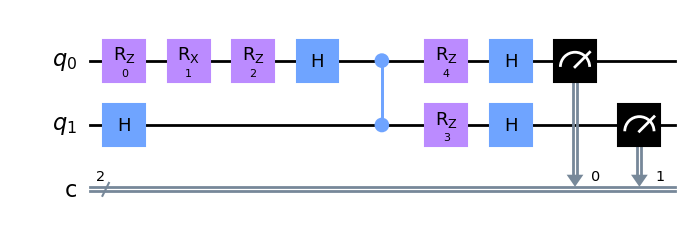

In [2]:
dev = qml.device("qiskit.aer", wires=2)
@qml.qnode(dev)
def circuit(x):
    qml.Hadamard(wires=1)
    qml.RZ(0,wires=0)
    qml.RX(1,wires=0)
    qml.RZ(2,wires=0)
    qml.Hadamard(wires=0)
    qml.CZ(wires=[1, 0])
    qml.RZ(3,wires=1)
    qml.RZ(4,wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=0)   
    return qml.expval(qml.PauliZ(0))

circuit([0,1,2,3,4])

dev._circuit.draw(output='mpl')

In [3]:
dev1 = qml.device('default.mixed', wires=2)

In [4]:
def real():
    qml.Hadamard(wires=1) 

In [5]:
def generator(w,**kwargs):
    qml.RZ(w[0],wires=0)
    qml.RX(w[1],wires=0)
    qml.RZ(w[2],wires=0)
    qml.BitFlip(p,wires=0)

In [6]:
def discriminator(w,**kwargs):
    qml.Hadamard(wires=0)
    qml.CZ(wires=[1, 0])
    qml.RZ(w[0],wires=1)
    qml.RZ(w[1],wires=0)
    qml.Hadamard(wires=1)
    qml.Hadamard(wires=0)
    qml.BitFlip(p,wires=0)
    qml.BitFlip(p,wires=1)

In [7]:
@qml.qnode(dev1, interface='tf')
def real_gen_disc_circuit(gen_weights, disc_weights):
    real()
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval((qml.Identity(0)-qml.PauliZ(0))@ (qml.Identity(1)-qml.PauliZ(1)))

In [8]:
p='p'
print(qml.draw(real_gen_disc_circuit)([ 0,0,0],[ 0,0]))

0: ──RZ(0.00)──RX(0.00)──RZ(0.00)──BitFlip(p)──H─╭Z──RZ(0.00)──H──BitFlip(p)─┤ ╭<𝓗>
1: ──H───────────────────────────────────────────╰●──RZ(0.00)──H──BitFlip(p)─┤ ╰<𝓗>


In [9]:
def prob_discriminated(gen_weights,disc_weights):
    discriminated_output = real_gen_disc_circuit(gen_weights, disc_weights)
    #convert to probability
    prob_discriminated_output = (discriminated_output)/4
    return prob_discriminated_output

In [10]:
def disc_cost(disc_weights):
    cost =1-prob_discriminated(gen_weights,disc_weights)
    return cost
def gen_cost(gen_weights):
    cost = prob_discriminated(gen_weights,disc_weights)
    return cost

In [11]:
@qml.qnode(dev1, interface="tf")
def circuit_gs(angles):
    generator(angles)
    return qml.state()
@qml.qnode(dev1, interface="tf")
def circuit_rs():
    real()
    return qml.state()

In [49]:
p = 0.01
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 2) + \
                   np.random.normal(scale=eps, size=(3,))
    
#init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)

# train only generator while discriminator is a perfect swap frozen discriminator
loss_val_d = []
loss_val_g = []
#step_d = []
step_gf = []
sg_f =[]
epochs = 6
a = 50
for i in range(epochs): 
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    #opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step1 = step+i*(a)
            step_gf.append(step1)
            print("Step {}: cost = {}".format(step1, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg_f.append(state_fidelity)
            
perfect_swap = sg_f
perfect_step_g = step_gf            

Step 0: cost = 0.24993230232493885
Step 5: cost = 0.248993584226339
Step 10: cost = 0.24680829278619107
Step 15: cost = 0.2431555471776345
Step 20: cost = 0.23783757049826215
Step 25: cost = 0.23070632430206026
Step 30: cost = 0.22168572404134296
Step 35: cost = 0.21078826478628437
Step 40: cost = 0.1981243541626202
Step 45: cost = 0.18390322624345107
Step 50: cost = 0.16930987601312267
Step 55: cost = 0.1575944066948298
Step 60: cost = 0.14554162879358842
Step 65: cost = 0.13326336779073666
Step 70: cost = 0.12089416690263743
Step 75: cost = 0.10858857235261765
Step 80: cost = 0.09651472827162597
Step 85: cost = 0.08484528577128875
Step 90: cost = 0.07374691419352591
Step 95: cost = 0.06336976506233138
Step 100: cost = 0.05370184265764508
Step 105: cost = 0.04433180669301148
Step 110: cost = 0.03587453188173256
Step 115: cost = 0.028459879699022028
Step 120: cost = 0.022174500559918625
Step 125: cost = 0.017048096788390588
Step 130: cost = 0.013046811661021507
Step 135: cost = 0.01007

In [ ]:
#step_g

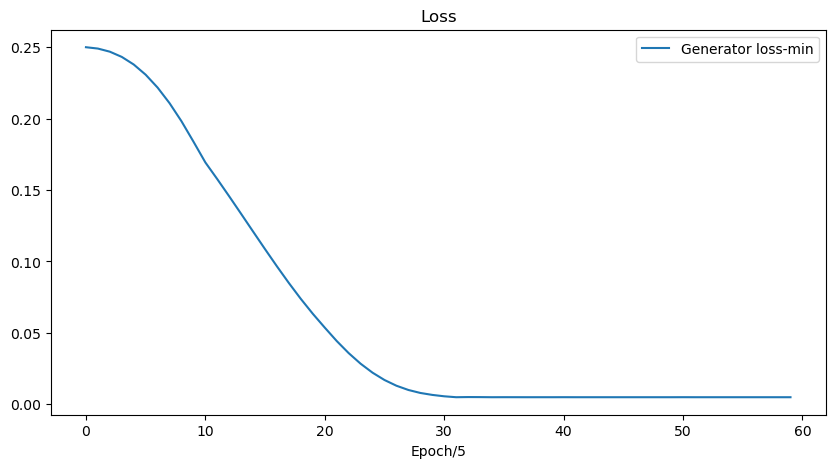

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_gf)), loss_val_g, label="Generator loss-min")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("Loss")
plt.xlabel("Epoch/5")
plt.legend()
plt.show()

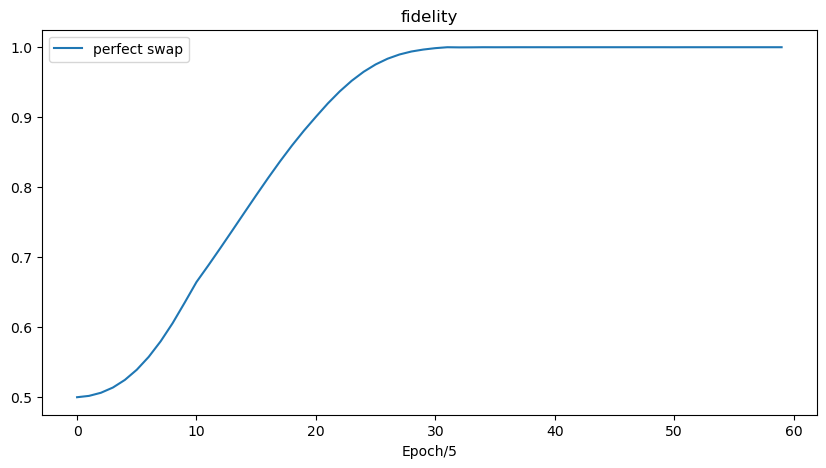

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(perfect_step_g)), perfect_swap, label="perfect swap")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch/5")
plt.legend()
plt.show()

In [ ]:
range(len(step_g))

In [ ]:
len(perfect_swap)

In [ ]:
len(perfect_step_g)

In [36]:
#  frozen discriminator + alternative training
#####
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 2) + \
                   np.random.normal(scale=eps, size=(3,))    
#init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)
#####

loss_val_d = []
loss_val_g = []
step_d = []
step_g = []
sg =[]

##
#fozen discriminator
epochs1 = 4
for i in range(epochs1):            
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    #opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    a1 = 40
    for step in range(a1):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step1 = step+i*(a1)
            step_g.append(step1)
            print("Step {}: cost = {}".format(step1, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)

#alternative training            
epochs2 = 2 
a2 = 10
a3 = 10
for i in range(epochs2):
    opt = tf.keras.optimizers.experimental.Adam(learning_rate=0.01)
    #opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.4)
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a2):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_d.append(loss_val)
            step2 = step+a1*epochs1+a2*i+a3*i
            step_d.append(step2)
            print("Step {}: cost = {}".format(step2, loss_val))  
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity) 
            
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    #opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a3):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step3 = step+a1*epochs1+a2*(i+1)+a3*(i)
            step_g.append(step3)
            print("Step {}: cost = {}".format(step3, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)
            
           

Step 0: cost = 0.24993230232493885
Step 5: cost = 0.248993584226339
Step 10: cost = 0.24680829278619107
Step 15: cost = 0.2431555471776345
Step 20: cost = 0.23783757049826215
Step 25: cost = 0.23070632430206026
Step 30: cost = 0.22168572404134296
Step 35: cost = 0.21078826478628437
Step 40: cost = 0.19881217903832799
Step 45: cost = 0.18849227693084142
Step 50: cost = 0.17749023775822148
Step 55: cost = 0.16587522595687035
Step 60: cost = 0.1537448832529913
Step 65: cost = 0.14122834254720829
Step 70: cost = 0.12848459009947022
Step 75: cost = 0.11569664239966992
Step 80: cost = 0.1031614602098741
Step 85: cost = 0.09130531366414499
Step 90: cost = 0.07984710095782563
Step 95: cost = 0.06893961206361185
Step 100: cost = 0.058731408030217314
Step 105: cost = 0.049355785640288335
Step 110: cost = 0.04091986180924234
Step 115: cost = 0.033495596915572357
Step 120: cost = 0.026889345664699416
Step 125: cost = 0.020445473659966157
Step 130: cost = 0.01516590169700105
Step 135: cost = 0.0111

In [ ]:
#step_g

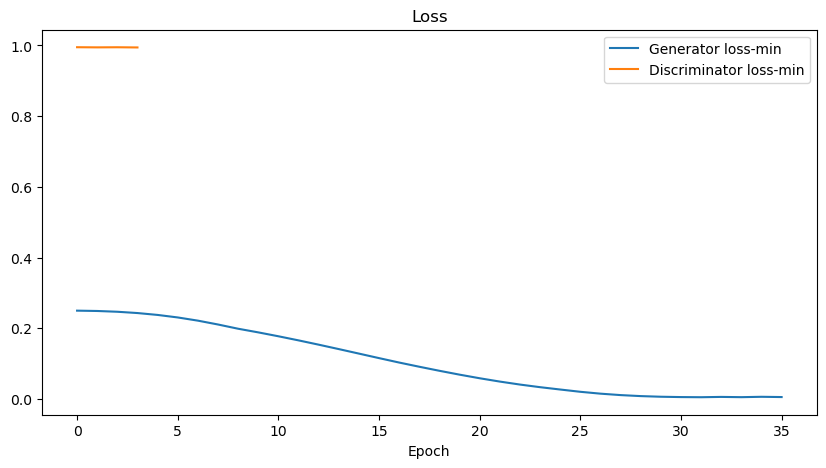

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g)), loss_val_g, label="Generator loss-min")
plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

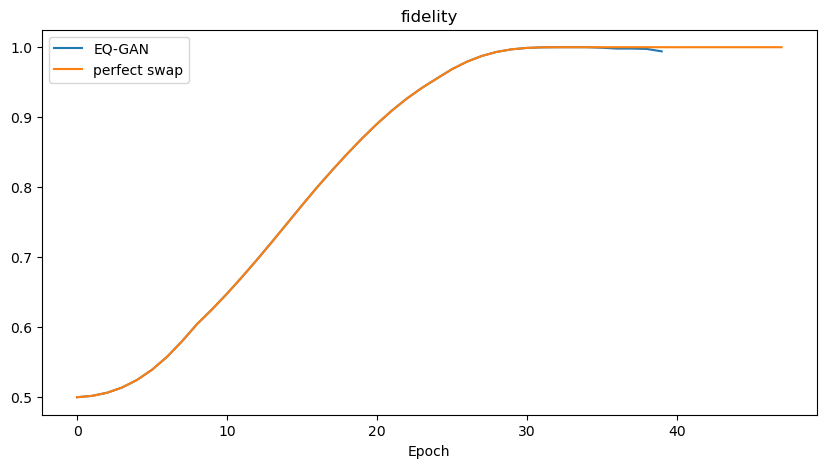

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g+step_d)), sg, label="EQ-GAN")
plt.plot(range(len(perfect_step_g)), perfect_swap, label="perfect swap")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [18]:
#  frozen discriminator + alternative training
#####
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 2) + \
                   np.random.normal(scale=eps, size=(3,))    
#init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)
#####

loss_val_d = []
loss_val_g = []
step_d = []
step_g = []
sg =[]

##
#fozen discriminator
epochs1 = 2
a1 = 40
for i in range(epochs1):            
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a1):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step1 = step+i*(a1)
            step_g.append(step1)
            print("Step {}: cost = {}".format(step1, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)

#alternative training            
epochs2 = 8
a2 = 2
a3 = 2
for i in range(epochs2):
    opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.4)
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a2):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_d.append(loss_val)
            step2 = step+a1*epochs1+a2*i+a3*i
            step_d.append(step2)
            print("Step {}: cost = {}".format(step2, loss_val))  
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity) 
            
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a3):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step3 = step+a1*epochs1+a2*(i+1)+a3*(i)
            step_g.append(step3)
            print("Step {}: cost = {}".format(step3, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)
            
           

Step 0: cost = 0.24998762834237442
Step 5: cost = 0.24996483856594381
Step 10: cost = 0.24990916100367533
Step 15: cost = 0.24976829315358096
Step 20: cost = 0.24941047173590702
Step 25: cost = 0.24850351471566878
Step 30: cost = 0.24622107858749415
Step 35: cost = 0.24058066545982854
Step 40: cost = 0.22725021715239135
Step 45: cost = 0.19884608782779709
Step 50: cost = 0.14998648172788948
Step 55: cost = 0.09121365460446304
Step 60: cost = 0.04565130084370167
Step 65: cost = 0.02141173395734633
Step 70: cost = 0.011143343823114743
Step 75: cost = 0.00723000988908043
Step 80: cost = 0.9939244893910483
Step 82: cost = 0.005967220559424752
Step 84: cost = 0.9941221760961179
Step 86: cost = 0.005804137796508929
Step 88: cost = 0.9942564808036919
Step 90: cost = 0.005693835054402185
Step 92: cost = 0.9943466873036625
Step 94: cost = 0.005620524831995211
Step 96: cost = 0.994405717055767
Step 98: cost = 0.005573633624311208
Step 100: cost = 0.9944422197270084
Step 102: cost = 0.00554608774

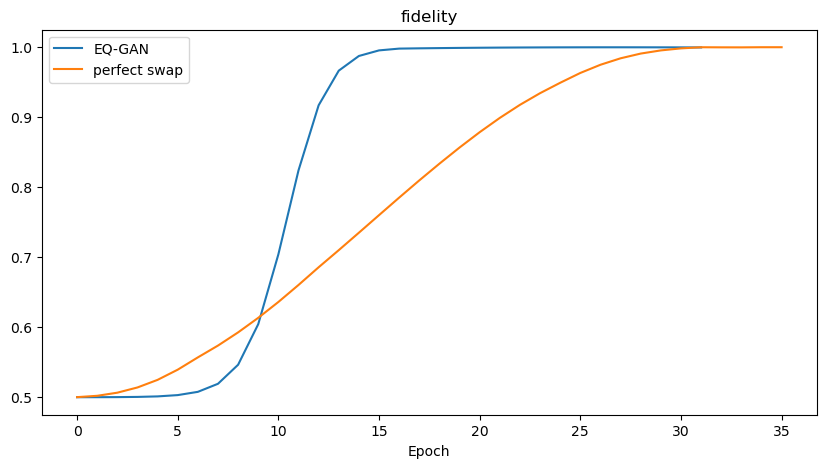

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g+step_d)), sg, label="EQ-GAN")
plt.plot(range(len(perfect_step_g)), perfect_swap, label="perfect swap")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [20]:
p

0.01

In [53]:
#  frozen discriminator + alternative training
#####
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 2) + \
                   np.random.normal(scale=eps, size=(3,))    
#init_gen_weights = np.array([0]*3)
#init_disc_weights = np.random.normal(size=(2,))
init_disc_weights = np.array([0]*2)
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)
#####

loss_val_d = []
loss_val_g = []
step_d = []
step_g = []
sg =[]

##
#fozen discriminator
epochs1 = 3
a1 = 50
for i in range(epochs1):            
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a1):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step1 = step+i*(a1)
            step_g.append(step1)
            print("Step {}: cost = {}".format(step1, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)

#alternative training            
epochs2 = 15
a2 = 2
a3 = 2
for i in range(epochs2):
    opt = tf.keras.optimizers.experimental.Adam(learning_rate=0.01)
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a2):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_d.append(loss_val)
            step2 = step+a1*epochs1+a2*i+a3*i
            step_d.append(step2)
            print("Step {}: cost = {}".format(step2, loss_val))  
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity) 
            
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    
    for step in range(a3):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            loss_val_g.append(loss_val)
            step3 = step+a1*epochs1+a2*(i+1)+a3*(i)
            step_g.append(step3)
            print("Step {}: cost = {}".format(step3, loss_val))
            red_r = qml.math.reduced_dm(circuit_rs(),indices=[1])
            red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
            state_fidelity = qml.math.fidelity(red_r, red_g)
            sg.append(state_fidelity)
            

Step 0: cost = 0.24993230232493885
Step 5: cost = 0.248993584226339
Step 10: cost = 0.24680829278619107
Step 15: cost = 0.2431555471776345
Step 20: cost = 0.23783757049826215
Step 25: cost = 0.23070632430206026
Step 30: cost = 0.22168572404134296
Step 35: cost = 0.21078826478628437
Step 40: cost = 0.1981243541626202
Step 45: cost = 0.18390322624345107
Step 50: cost = 0.16930987601312267
Step 55: cost = 0.1575944066948298
Step 60: cost = 0.14554162879358842
Step 65: cost = 0.13326336779073666
Step 70: cost = 0.12089416690263743
Step 75: cost = 0.10858857235261765
Step 80: cost = 0.09651472827162597
Step 85: cost = 0.08484528577128875
Step 90: cost = 0.07374691419352591
Step 95: cost = 0.06336976506233138
Step 100: cost = 0.05370184265764508
Step 105: cost = 0.04433180669301148
Step 110: cost = 0.03587453188173256
Step 115: cost = 0.028459879699022028
Step 120: cost = 0.022174500559918625
Step 125: cost = 0.017048096788390588
Step 130: cost = 0.013046811661021507
Step 135: cost = 0.01007

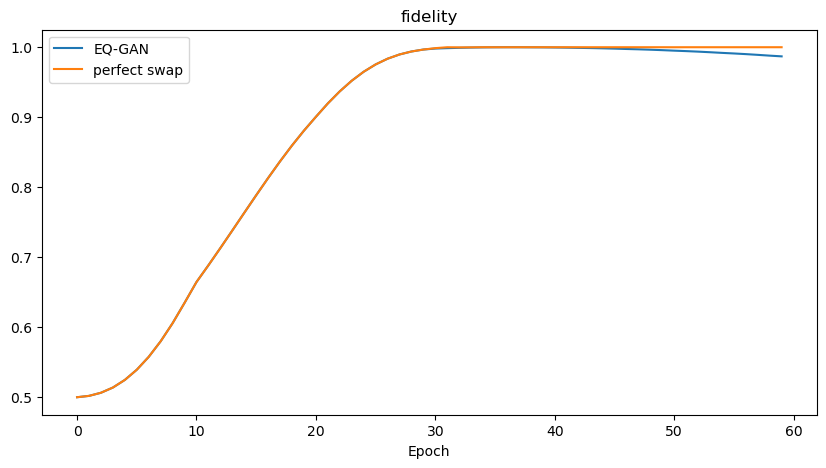

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(len(step_g+step_d)), sg, label="EQ-GAN")
plt.plot(range(len(perfect_step_g)), perfect_swap, label="perfect swap")
#plt.plot(range(len(step_d)), loss_val_d, label="Discriminator loss-min")
plt.title("fidelity")
plt.xlabel("Epoch")
plt.legend()
plt.show()